Dieser Block erzeugt eine Darstellung, die die ganze Breite des Fensters ausnutzt.

In [1]:
%%HTML 
<style>.container{width:100%;}</style>

Dieser Block schaltet die Überprüfung auf Schönheitsfehler ein. Damit dies funktioniert, müssen zusätzliche Pakete mit `conda install --file requirements.txt && pip install -r pip_only_requirements.txt` bzw. `pip install -r all_requirements.txt` installiert werden. Wir ignorieren die Konvention, dass zwischen Definitionen zwei Leerzeichen stehen sollen, um die Lesbarkeit zu erhöhen.

In [2]:
%load_ext pycodestyle_magic
%flake8_on --ignore E302,E305

Wir benötigen *GraphViz* zur Visualisierung (wird ebenfalls mit den Befehlen oben installiert). Wir benötigen ebenfalls die *double-ended queue* aus den `collections`, die schon in Python-Distributionen enthalten sind.

In [3]:
from graphviz import Digraph
from collections import deque

# Splay Trees

In diesem Notebook wird eine bestimmte Art von selbstbalancierenden Bäumen gezeigt, die *Splay Trees*. Diese Datenstruktur wurde [1985 von Sleator und Tarjan eingeführt](http://www.cs.cmu.edu/~sleator/papers/self-adjusting.pdf "D. D. Sleator, R. E. Tarjan (1985): Self-Adjusting Binary Search Trees. Journal of the ACM, 32(3) 652-686"). Im Gegensatz zu anderen selbstbalancierenden Bäumen wie *AVL-Bäumen* wird bei Splay Trees nicht gefordert, dass der Baum zu allen Zeiten so gut wie möglich balanciert ist. Stattdessen wird der Baum dahingehend optimiert, dass häufig verwendete Elemente nahe an der Wurzel sind.

Auf Basis dieser Bäume soll später eine alternative Implementierung von Mengen in der Programmiersprache Python entstehen. In der Referenzimplementierung *CPython* sind [Mengen auf Basis von *Hashtabellen* implementiert](https://github.com/python/cpython/blob/3.8/Objects/setobject.c "R. D. Hettinger et al. (2019): cpython/Objects/setobject.c, GitHub"). Viele andere weit verbreitete Implementierungen anderer Programmiersprachen benutzen für Mengen ebenfalls Hashtabellen oder haben dies zumindest als Option, wie in [Java](https://docs.oracle.com/en/java/javase/13/docs/api/java.base/java/util/Set.html "Oracle Corp. (2019): Set (Java SE13 & JDK 13)"), [.NET (C#)](https://docs.microsoft.com/en-us/dotnet/api/system.collections.generic.iset-1?view=netframework-4.8, "Microsoft Corp. (2019): ISet<T> Interface (System.Collections.Generic), Microsoft Docs"), [JavaScript](https://v8.dev/blog/hash-code "Sathya Gunasekaran (2018): Optimizing hash tables: hiding the hash code, V8 Blog") oder [PHP](https://www.php.net/manual/en/class.ds-set.php "The PHP Group (2019): PHP: Set, Manual"). Jedoch macht die Verwendung von Bäumen für Mengen einige mengenlastige Programmierprobleme einfacher zu lösen, da diese Mengen *geordnet* sind und somit beispielsweise ein einfach zu bestimmendes Minimum und ein Maximum haben.

Geordnete binäre Bäume eignen sich, um Mengen zu implementieren, da insbesondere in beiden keine doppelten Elemente vorkommen. Wir müssen für geordnete Mengen außerdem fordern, dass alle Elemente geordnet werden können. Wir behandeln später, wie wir beliebigen Nutzlasten in Python eine Ordnung geben können.

Die reine Datenstruktur – ohne Operationen – ist bei Splay Trees genauso wie bei regulären geordneten binären Bäumen definiert: $\text{Node}(p, l, r)$ ist ein Baum, wobei
- $p$ eine Nutzlast (payload) ist,
- $l$ der linke Teilbaum ist und
- $r$ der rechte Teilbaum ist.

In [4]:
class Node:
    def __init__(self, payload, left, right):
        self.payload = payload
        self.left = left
        self.right = right

Wir verlangen dabei:

- Für alle Nutzlasten aus dem linken Teilbaum $l$ gilt, dass sie kleiner als die Nutzlast $p$ sind.
- Für alle Nutzlasten aus dem rechten Teilbaum $r$ gilt, dass sie größer als die Nutzlast $p$ sind.

Diese Aussagen können auch als $l < p < r$ formuliert werden.

## Visualisierung

Wir definieren zunächst die Methode `graph`, die einen Baum auf Basis von dem [Python-Interface](https://github.com/xflr6/graphviz "S. Bank (2019): graphviz, GitHub") zu [*Graphviz*](https://graphviz.org/ "J. Ellson et al. (2019): Graphviz") visualisiert. Dies erleichtert später die Erklärungen anderer Operationen. `graph` benutzt `_graph`, eine Methode, die einem bestehenden Graphen die Knoten hinzufügt. `_graph` nimmt zusätzlich eine Menge von benutzten Schlüsseln für die Knoten und einen Zähler, der Schlüssel für leere Blätter im Baum liefert. `graph` nimmt optional eine Liste von Objekten, die ebenfalls `_graph` unterstützen. Dies können wir benutzen, um eine Transformation im Baum zu zeigen. Zur besseren Illustrierung kann dazwischen ein Objekt der Klasse `Method` benutzt werden, die wir ebenfalls definieren. Wir benötigen ebenfalls zum Illustrieren einen Baum, der nur ein Kind hat, den `UnaryTree`.

In [5]:
def graph(self, *additionals):
    dot = Digraph()
    used, key = self._graph(dot, set(), 0)
    for el in additionals:
        used, key = el._graph(dot, used, key)
    return dot


def _graph(self, dot, used, key):
    used.add(id(self))
    dot.node(str(id(self)), label=str(self.payload))
    if not (self.left is None and self.right is None):
        for node in self.left, self.right:
            if node is not None:
                dot.edge(str(id(self)), str(id(node)))
                used, key = node._graph(dot, used, key)
            else:
                while True:
                    key += 1
                    if key not in used:
                        break
                used.add(key)
                dot.node(str(key), shape="point")
                dot.edge(str(id(self)), str(key))
    return used, key


Node.graph = graph
Node._graph = _graph
del graph
del _graph


class Method:
    def __init__(self, name):
        self.name = name

    def _graph(self, dot, used, key):
        used.add(id(self))
        dot.node(str(id(self)), label=str(self.name) + " ⇒",
                 shape="rectangle", style="dotted")
        return used, key


class UnaryTree:
    def __init__(self, name, child):
        self.name = name
        self.child = child

    def graph(self, *additionals):
        dot = Digraph()
        used, key = self._graph(dot, set(), 0)
        for el in additionals:
            used, key = el._graph(dot, used, key)
        return dot

    def _graph(self, dot, used, key):
        used.add(id(self))
        dot.node(str(id(self)), label=str(self.name), shape="triangle")
        if self.child is not None:
            dot.edge(str(id(self)), str(id(self.child)))
            used, key = self.child._graph(dot, used, key)
        return used, key

## Splaying

Die Besonderheit von Splay Trees ist, dass mit allen Baumoperationen, die ein Element im Baum lokalisieren, eine besondere Operation, der *Splay*, durchgeführt wird. Mit Baumoperationen, die ein Element im Baum lokalisieren, sind alle Operationen auf den Baum gemeint, die den Baum auf der Suche nach einem Element oder auf der Suche nach dem richtigen Ort für ein Element durchsuchen. Dazu gehören das Einfügen, Löschen und Finden von Elementen.

Der Splay ist eine Funktion, die einen Baum dahingehend modifiziert, dass eine Nutzlast, die schon im Baum enthalten ist, die neue Wurzel des Baums wird.

$$\text{splay}: \text{Node} \times \text{Payload} \to \text{Node}$$

Ist die angegebene Nutzlast im Baum, so ist gerade der Knoten, der sie enthält, die neue Wurzel.

Wir arbeiten mit dem *Top-Down*-Ansatz, bei dem wir von der Wurzel aus so lange Knoten beiseite legen, bis der zu splayende Knoten die Wurzel darstellt, und diese beiseite gelegten Knoten wieder unterordnen. Dieser Ansatz wurde in der ursprünglichen Veröffentlichung bereits beschrieben (S. 667ff.), aber erst [1987 von Mäkinen als in Komplexität etwas begrenzter analysiert](https://link.springer.com/article/10.1007%2FBF01933728 "E. Mäkinen (1987): On top-down splaying. BIT Numerical Mathematics, 27 330-339 (SpringerLink)").

Beim Top-Down-Splaying werden die drei Bäume $L, M, R$ (links, mitte, rechts) betrachtet. Der Baum, der bearbeitet wird, ist $M$. Wenn Knoten beiseite gelegt werden, so werden sie in $L$ und $R$ abgelegt. In $L$ kommen die Elemente, die kleiner als der zu splayende Knoten sind, in $R$ die, die größer sind. Dabei bleiben der rechteste Knoten von $L$ und der linkeste Knoten von $R$ immer frei, sodass dort leicht angefügt werden kann.

Der Splay findet schrittweise statt, in jedem Schritt werden zwei Knoten beiseite gelegt. Sollte der Knoten auf der zweitobersten Ebene sein, so wird natürlich nur noch ein Knoten beiseite gelegt. Diesen Schritt behandeln wir zuerst. Ist der Knoten dabei das linke Kind seines Elternknotens, so bezeichnen wir diesen Schritt als *Zig*.

### Zig und Zag

Die folgende Grafik illustriert den Schritt. Dreiecke stehen hier für ganze Bäume.

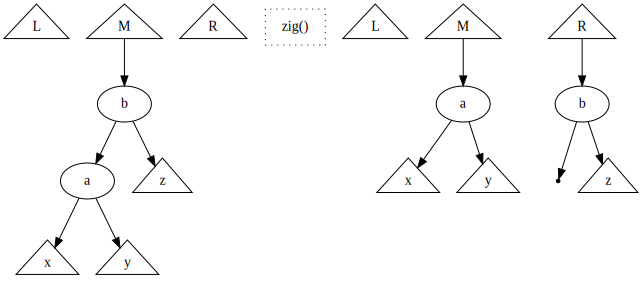

In [6]:
# flake8: noqa
# blocks solely for drawing are exempt because I consider
# semicolons and longer lines more beneficial to the reading flow
x1 = Node("x", None, None); y1 = Node("y", None, None); z1 = Node("z", None, None)
a1 = Node("a", x1, y1); b1 = Node("b", a1, z1)
l1 = UnaryTree("L", None); m1 = UnaryTree("M", b1); r1 = UnaryTree("R", None)

x2 = Node("x", None, None); y2 = Node("y", None, None); z2 = Node("z", None, None)
a2 = Node("a", x2, y2); b2 = Node("b", None, z2)
l2 = UnaryTree("L", None); m2 = UnaryTree("M", a2); r2 = UnaryTree("R", b2)

dot = l1.graph(m1, r1, Method("zig()"), l2, m2, r2)
for subtree in x1, y1, z1, x2, y2, z2:
    dot.node(str(id(subtree)), shape="triangle")
dot

Wir bewegen den Knoten $a$ an die Wurzel, wobei $b$ gemeinsam mit seinem rechten Teilbaum $z$ links unten an $R$ angefügt wird. Die Ordnung bleibt erhalten, da $b > a$ ist, und da alle Elemente, die zuvor schon in $R$ waren, auch größer als $b$ sind.

Formal definieren wir $\text{zig}()$ unter der Angabe der momentanen Extrema in $L, R$ als Parameter als

$$\text{Node}(b, \text{Node}(a, x, y), z).\text{zig}(\text{max_}L, \text{min_}R) = \text{new_min_}R := \text{Node}(b, \text{Nil}, z); \text{min_}R.\text{left} := \text{new_min_}R; (\text{min_}L, \text{Node}(a, x, y), \text{new_min_}R)$$

wobei wir ein Tripel aus dem ungeänderten Maximum in $L$, aus der neuen Mitte und dem neuen Minimum in $R$ zurückgeben. Diese unveränderte Rückgabe erleichtert später die Definition des Splays als ganzen.

In Code definieren wir:

In [7]:
def _zig(self, max_less, min_greater):
    min_greater.left = self
    min_greater = self
    self = self.left
    min_greater.left = None
    return self, max_less, min_greater

Node._zig = _zig
del _zig

Um das vergleichsweise teure Konstruieren neuer Objekte zu vermeiden, schreiben wir lediglich die Referenzen um. Weniger geschrieben würde auch, wenn wir, statt lokale Variablen zu überschreiben, die neuen Werte direkt zurückgeben würden. Wir werden aber später die Schritte ohnehin in eine Methode schreiben, sodass dies nur die Lesbarkeit behindern würde.

Ähnlich definieren wir *Zag*, bei dem der zu splayende Knoten das rechte Kind der Wurzel ist. Hier modifizieren wir das Maximum in $L$.

$$\text{Node}(b, x, \text{Node}(a, y, z)).\text{zag}(\text{max_}L, \text{min_}R) = \text{new_max_}L := \text{Node}(b, x, \text{Nil}); \text{max_L}.\text{right} := \text{new_max_}L; (\text{new_max_}L, \text{Node}(a, y, z), \text{min_}R)$$

In [8]:
def _zag(self, max_less, min_greater):
    max_less.right = self
    max_less = self
    self = self.right
    max_less.right = None
    return max_less, self, min_greater

Node._zag = _zag
del _zag

### Zig-Zig und Zag-Zag

Als nächstes behandeln wir den Fall, dass der Knoten wenigstens zwei Ebenen von der Wurzel entfernt ist, und sowohl der Knoten als auch sein Elternknoten ein linkes Kind sind. Die Operation, die auf diese Ausgangssituation anzuwenden ist, bezeichnen wir als *Zig-Zig*. Diese Operation sieht so aus:

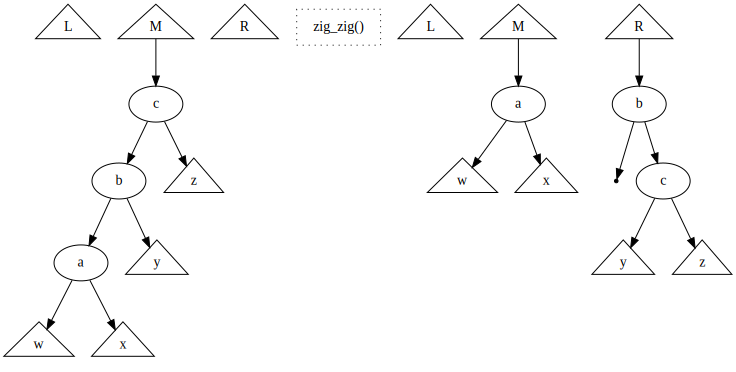

In [9]:
# flake8: noqa
w1 = Node("w", None, None); x1 = Node("x", None, None); y1 = Node("y", None, None); z1 = Node("z", None, None)
a1 = Node("a", w1, x1); b1 = Node("b", a1, y1); c1 = Node("c", b1, z1)
l1 = UnaryTree("L", None); m1 = UnaryTree("M", c1); r1 = UnaryTree("R", None)

w2 = Node("w", None, None); x2 = Node("x", None, None); y2 = Node("y", None, None); z2 = Node("z", None, None)
a2 = Node("a", w2, x2); c2 = Node("c", y2, z2); b2 = Node("b", None, c2)
l2 = UnaryTree("L", None); m2 = UnaryTree("M", a2); r2 = UnaryTree("R", b2)

dot = l1.graph(m1, r1, Method("zig_zig()"), l2, m2, r2)
for subtree in w1, x1, y1, z1, w2, x2, y2, z2:
    dot.node(str(id(subtree)), shape="triangle")
dot

Wir bewegen den Knoten $a$ an die Wurzel. $b$ wird mit $c$ als rechtes Kind an $R$ angefügt, wobei $c$ als seinen linken Teilbaum $y$ hat. Die Ordnungsbedingung bleibt erhalten, da $c > b > a$ und $y > c > b$ ist.

Wir definieren unter Angabe der Extrema

$$\text{Node}(c, \text{Node}(b, \text{Node}(a, w, x), y), z).\text{zig_zig}(\text{max_}L, \text{min_}R) = \text{new_min_}R := \text{Node}(b, \text{Nil}, \text{Node}(c, y, z)); \text{min_}R.\text{left} := \text{new_min_}R; (\text{max_}L, \text{Node}(a, w, x), \text{new_min_}R$$

und in Code

In [10]:
def _zig_zig(self, max_less, min_greater):
    tmp = self.left
    self.left = tmp.right
    tmp.right = self
    min_greater.left = tmp
    min_greater = tmp
    self = tmp.left
    min_greater.left = None
    return max_less, self, min_greater

Node._zig_zig = _zig_zig
del _zig_zig

Wir bezeichnen die gleiche Situation mit rechtem Kind und rechtem Enkel als *Zag-Zag*. Der Splay-Schritt ist ähnlich definiert.

$$\text{Node}(c, w, \text{Node}(b, x, \text{Node}(a, y, z))).\text{zag_zag}(\text{max_}L, \text{min_}R) = \text{new_max_}L := \text{Node}(b, \text{Node}(c, w, x), \text{Nil}); \text{max_}L.\text{right} := \text{new_max_}L; (\text{new_max_}L, \text{Node}(a, y, z), \text{min_}R)$$

In [11]:
def _zag_zag(self, max_less, min_greater):
    tmp = self.right
    self.right = tmp.left
    tmp.left = self
    max_less.right = tmp
    max_less = tmp
    self = tmp.right
    max_less.right = None
    return max_less, self, min_greater

Node._zag_zag = _zag_zag
del _zag_zag

### Zig-Zag und Zag-Zig

Zuletzt behandeln wir den Fall, dass der Elternknoten ein linkes Kind, der Knoten selbst aber ein rechtes Kind ist. Die Operation auf diese Situation nennen wir *Zig-Zag*. Für diese Operation brauchen wir erstmalig sowohl $L$ als auch $R$:

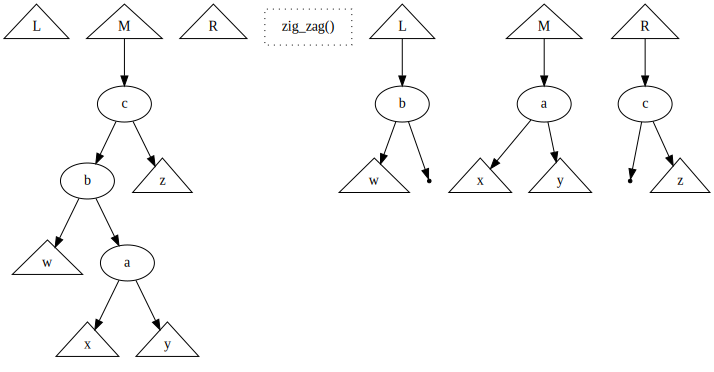

In [12]:
# flake8: noqa
w1 = Node("w", None, None); x1 = Node("x", None, None)
y1 = Node("y", None, None); z1 = Node("z", None, None)
a1 = Node("a", x1, y1); b1 = Node("b", w1, a1); c1 = Node("c", b1, z1)
l1 = UnaryTree("L", None); m1 = UnaryTree("M", c1); r1 = UnaryTree("R", None)

w2 = Node("w", None, None); x2 = Node("x", None, None)
y2 = Node("y", None, None); z2 = Node("z", None, None)
a2 = Node("a", x2, y2); b2 = Node("b", w2, None); c2 = Node("c", None, z2)
l2 = UnaryTree("L", b2); m2 = UnaryTree("M", a2); r2 = UnaryTree("R", c2)

dot = l1.graph(m1, r1, Method("zig_zag()"), l2, m2, r2)
for subtree in w1, x1, y1, z1, w2, x2, y2, z2:
    dot.node(str(id(subtree)), shape="triangle")
dot

Wir bewegen den Knoten $a$ an die Stelle von $c$, dabei werden $b$ und $c$ respektive an $L$ und $R$ angefügt, die ja jeweils kleiner bzw. größer als $a$ sind.

Wir definieren, diesmal unter Angabe beider Extrema

$$\text{Node}(c, \text{Node}(b, w, \text{Node}(a, x, y)), z).\text{zig_zag}(\text{max_}L, \text{min_}R) = \text{new_max_}L := \text{Node}(b, w, \text{Nil}); \text{max_}L.\text{right} := \text{new_max_}L;$$
$$\text{new_min_}R := \text{Node}(c, \text{Nil}, z); \text{max_}R.\text{left} := \text{new_max_}R; (\text{new_max_}L, \text{Node}(a, x, y), \text{new_min_}R)$$

und erhalten auch beide neuen Extrema zurück.

In Code haben wir

In [13]:
def _zig_zag(self, max_less, min_greater):
    max_less.right = self.left
    max_less = self.left
    min_greater.left = self
    min_greater = self
    self = self.left.right
    max_less.right = None
    min_greater.left = None
    return max_less, self, min_greater

Node._zig_zag = _zig_zag
del _zig_zag

In umgekehrter Reihenfolge, d.h. der Elternknoten ist das rechte Kind, der Knoten das linke Kind, haben wir die Operation *Zag-Zig* mit

$$\text{Node}(c, w, \text{Node}(b, \text{Node}(a, x, y), z)).\text{zag_zig}(\text{max_}L, \text{min_}R) = \text{new_max_}L := \text{Node}(c, w, \text{Nil}); \text{max_}L.\text{right} := \text{new_max_}L;$$
$$\text{new_min_}R := \text{Node}(b, \text{Nil}, z); \text{min_}R.\text{left} := \text{new_min_}R; \text{Node}(a, x, y); (\text{new_max_}L, \text{Node}(a, x, y), \text{new_min_}R$$

In [14]:
def _zag_zig(self, max_less, min_greater):
    max_less.right = self
    max_less = self
    min_greater.left = self.right
    min_greater = self.right
    self = self.right.left
    max_less.right = None
    min_greater.left = None
    return max_less, self, min_greater

Node._zag_zig = _zag_zig
del _zag_zig

### Vergleich beliebiger Nutzlasten

Wir müssen, um später Mengen, die Elemente unterschiedlicher Typen enthalten, zu unterstützen, dazu in der Lage sein, beliebige Nutzlasten zu vergleichen. Dazu versuchen wir den direkten Vergleich, und vergleichen, wenn das nicht funktioniert, am Klassennamen. So kommen wertgleiche Fließkomma- und Ganzzahlen nur einmal in die Menge (dies ist auch bei Python-Mengen so). Für Gleichheit erlauben wir beliebig viele Operanden, jedoch mindestens zwei.

In [15]:
def _arb_gt(self, x, y):
    try:
        return x > y
    except TypeError:
        return type(x).__name__ > type(y).__name__


def _arb_lt(self, x, y):
    try:
        return x < y
    except TypeError:
        return type(x).__name__ < type(y).__name__


def _arb_eq(self, x, arg, *args):
    try:
        for y in [arg, *args]:
            if x != y:
                return False
        return True
    except TypeError:
        return False


Node._arb_gt = _arb_gt
Node._arb_lt = _arb_lt
Node._arb_eq = _arb_eq
del _arb_gt, _arb_lt, _arb_eq

### Verkettung der Schritte

Das *Splayen* eines Knotens, also das Bewegen an die Wurzel, funktioniert durch das wiederholte Durchführen der Zig-, Zig-Zig- und Zig-Zag-Schritte (und umgekehrt), bis alle Elternknoten dieses Knotens beiseite gelegt sind.

Falls der gesuchte Knoten noch genau eine Ebene entfernt ist, so führen wir Zig bzw. Zag durch. In diesem Fall unterscheiden wir:

|Linkes Kind|Rechtes Kind|
|:---------:|:----------:|
|Zig        |Zag         |

Falls er noch mindestens zwei Ebenen entfernt ist, so unterscheiden wir:

|                 |Linkes Kind|Rechtes Kind|
|----------------:|:---------:|:----------:|
|**Linker Enkel** |Zig-Zig    |Zig-Zag     |
|**Rechter Enkel**|Zag-Zig    |Zag-Zag     |

oder formaler, wobei wir den gesuchten Knoten als $\text{sought}$ bezeichnen:

- $M = \text{Node}(v, \text{Node}(w, x, y), z) \land \text{sought} = w \Rightarrow M.\text{splay_step}() = M.\text{zig}(\text{max_}L, \text{min_}R)$
- $M = \text{Node}(v, w, \text{Node}(x, y, z)) \land \text{sought} = x \Rightarrow M.\text{splay_step}() = M.\text{zag}(\text{max_}L, \text{min_}R)$
- $M = \text{Node}(v, \text{Node}(w, x, y), z) \land \text{sought} < w \Rightarrow M.\text{splay_step}() = M.\text{zig_zig}(\text{max_}L, \text{min_}R)$
- $M = \text{Node}(v, w, \text{Node}(x, y, z)) \land \text{sought} > x \Rightarrow M.\text{splay_step}() = M.\text{zag_zag}(\text{max_}L, \text{min_}R)$
- $M = \text{Node}(v, \text{Node}(w, x, y), z) \land \text{sought} > w \Rightarrow M.\text{splay_step}() = M.\text{zig_zag}(\text{max_}L, \text{min_}R)$
- $M = \text{Node}(v, w, \text{Node}(x, y, z)) \land \text{sought} < x \Rightarrow M.\text{splay_step}() = M.\text{zag_zig}(\text{max_}L, \text{min_}R)$

Die Schritte werden wiederholt, bis an der Wurzel festgestellt werden kann, ob der gesuchte Knoten vorhanden ist. In diesem Fall fügen wir noch die Teilbäume von der neuen Wurzel an $L, R$ an und setzen $L, R$ als Teilbäume dieser neuen Wurzel.

- $M = \text{Node}(x, y, z) \land \lnot(\text{sought} = x \lor (x < \text{sought} \land y = \text{Nil}) \lor (x > \text{sought} \land z = \text{Nil})) \Rightarrow M.\text{splay}() = \text{max_}L, M, \text{min_}R := M.\text{splay_step}()$
- $M = \text{Node}(x, y, z) \land (\text{sought} = x \lor (x < \text{sought} \land y = \text{Nil}) \lor (x > \text{sought} \land z = \text{Nil})) \Rightarrow M.\text{splay}() = \text{max_}L.\text{right} := y; \text{min_}R.\text{left} := z; \text{Node}(x, L, R)$

Die Implementierung halten wir *iterativ*, um Funktionsaufrufe und Grenzen von Rekursionstiefe zu vermeiden:

In [16]:
def _splay(self, payload):
    max_less = min_greater = set_aside = Node(None, None, None)
    while True:
        if self._arb_lt(payload, self.payload):
            if self.left is None:
                break
            if (self._arb_lt(payload, self.left.payload)
                    and self.left.left is not None):
                max_less, self, min_greater = self._zig_zig(max_less,
                                                            min_greater)
                continue
            if (self._arb_gt(payload, self.left.payload)
                    and self.left.right is not None):
                max_less, self, min_greater = self._zig_zag(max_less,
                                                            min_greater)
                continue
            max_less, self, min_greater = self._zig(max_less, min_greater)
            break
        if self._arb_gt(payload, self.payload):
            if self.right is None:
                break
            if (self._arb_gt(payload, self.right.payload)
                    and self.right.right is not None):
                max_less, self, min_greater = self._zag_zag(max_less,
                                                            min_greater)
                continue
            if (self._arb_lt(payload, self.right.payload)
                    and self.right.left is not None):
                max_less, self, min_greater = self._zag_zig(max_less,
                                                            min_greater)
                continue
            max_less, self, min_greater = self._zag(max_less, min_greater)
            break
        break
    max_less.right = self.left
    min_greater.left = self.right
    self.left = set_aside.right
    self.right = set_aside.left
    return self


Node._splay = _splay
del _splay

Das nächste Beispiel zeigt, wie ein Splay aus einem schlechtestmöglich balancierten Baum einen deutlich besser balancierten Baum machen kann:

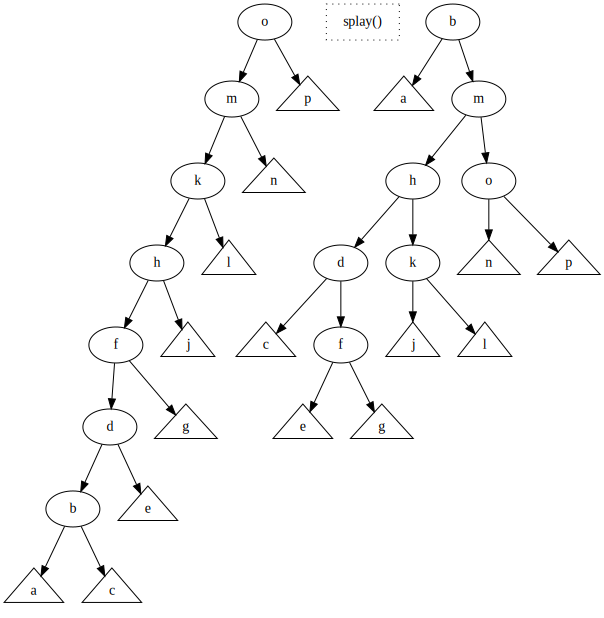

In [17]:
# flake8: noqa
a1 = Node("a", None, None); c1 = Node("c", None, None); e1 = Node("e", None, None); g1 = Node("g", None, None)
j1 = Node("j", None, None); l1 = Node("l", None, None); n1 = Node("n", None, None); p1 = Node("p", None, None)
b1 = Node("b", a1, c1); d1 = Node("d", b1, e1); f1 = Node("f", d1, g1); h1 = Node("h", f1, j1)
k1 = Node("k", h1, l1); m1 = Node("m", k1, n1); o1 = Node("o", m1, p1)

a2 = Node("a", None, None); c2 = Node("c", None, None); e2 = Node("e", None, None); g2 = Node("g", None, None)
j2 = Node("j", None, None); l2 = Node("l", None, None); n2 = Node("n", None, None); p2 = Node("p", None, None)
b2 = Node("b", a2, c2); d2 = Node("d", b2, e2); f2 = Node("f", d2, g2); h2 = Node("h", f2, j2)
k2 = Node("k", h2, l2); m2 = Node("m", k2, n2); o2 = Node("o", m2, p2)

dot = o1.graph(Method("splay()"), o2._splay("b"))
for subtree in a1, c1, e1, g1, j1, l1, n1, p1, a2, c2, e2, g2, j2, l2, n2, p2:
    dot.node(str(id(subtree)), shape="triangle")
dot

Ein anderes Beispiel enthält alle Schritte außer Zag:

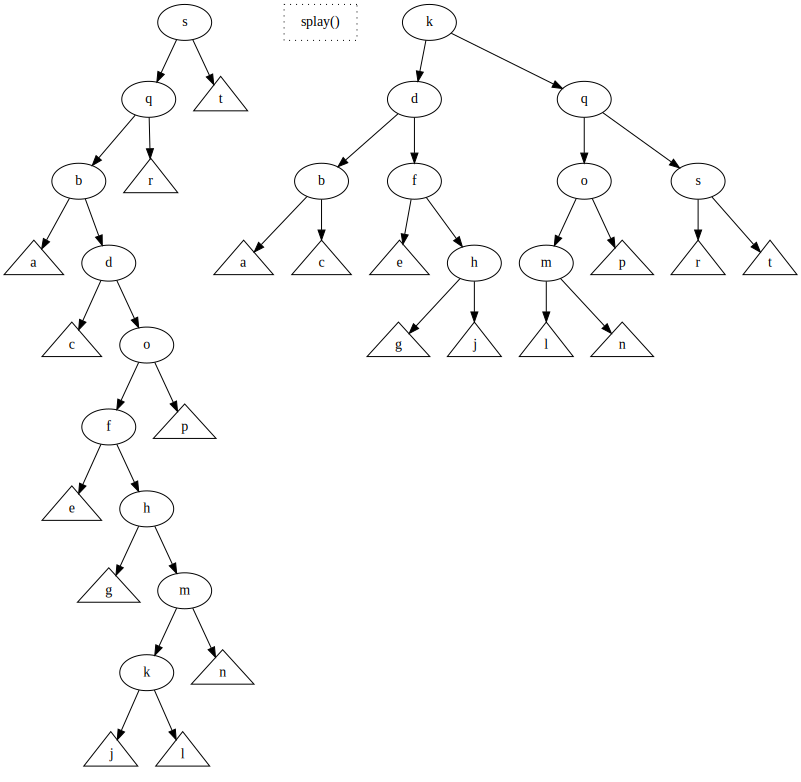

In [18]:
# flake8: noqa
j1 = Node("j", None, None); l1 = Node("l", None, None); n1 = Node("n", None, None); g1 = Node("g", None, None)
e1 = Node("e", None, None); p1 = Node("p", None, None); c1 = Node("c", None, None); a1 = Node("a", None, None)
r1 = Node("r", None, None); t1 = Node("t", None, None)
k1 = Node("k", j1, l1); m1 = Node("m", k1, n1); h1 = Node("h", g1, m1); f1 = Node("f", e1, h1)
o1 = Node("o", f1, p1); d1 = Node("d", c1, o1); b1 = Node("b", a1, d1); q1 = Node("q", b1, r1)
s1 = Node("s", q1, t1)

j2 = Node("j", None, None); l2 = Node("l", None, None); n2 = Node("n", None, None); g2 = Node("g", None, None)
e2 = Node("e", None, None); p2 = Node("p", None, None); c2 = Node("c", None, None); a2 = Node("a", None, None)
r2 = Node("r", None, None); t2 = Node("t", None, None)
k2 = Node("k", j2, l2); m2 = Node("m", k2, n2); h2 = Node("h", g2, m2); f2 = Node("f", e2, h2)
o2 = Node("o", f2, p2); d2 = Node("d", c2, o2); b2 = Node("b", a2, d2); q2 = Node("q", b2, r2)
s2 = Node("s", q2, t2)

dot = s1.graph(Method("splay()"), s2._splay("k"))
for subtree in a1, c1, e1, g1, j1, l1, n1, p1, r1, t1, a2, c2, e2, g2, j2, l2, n2, p2, r2, t2:
    dot.node(str(id(subtree)), shape="triangle")
dot

Wir betrachten zuletzt das folgende Beispiel, um Zag abgedeckt zu haben:

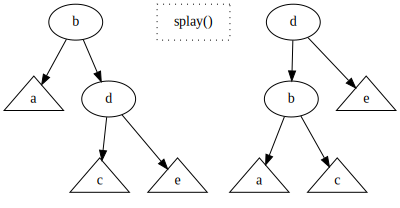

In [19]:
# flake8: noqa
a1 = Node("a", None, None); c1 = Node("c", None, None); e1 = Node("e", None, None)
d1 = Node("d", c1, e1); b1 = Node("b", a1, d1)

a2 = Node("a", None, None); c2 = Node("c", None, None); e2 = Node("e", None, None)
d2 = Node("d", c2, e2); b2 = Node("b", a2, d2)

dot = b1.graph(Method("splay()"), b2._splay("d"))
for subtree in a1, c1, e1, a2, c2, e2:
    dot.node(str(id(subtree)), shape="triangle")
dot

Schließlich definieren wir `_splay()` so, dass die Routinen für die einzelnen Schritte nicht in eigenen Methoden aufgerufen werden, um Aufrufe zu sparen. Wir überschreiben auch nicht die inneren Teilbäume der neuen Extrema mit `None`, da diese sowieso in jedem Schritt sowie am Ende überschrieben werden.

In [20]:
def _splay(self, payload):
    max_less = min_greater = set_aside = Node(None, None, None)
    while True:
        if self._arb_lt(payload, self.payload):
            if self.left is None:
                break
            if (self._arb_lt(payload, self.left.payload)
                    and self.left.left is not None):
                tmp = self.left
                self.left = tmp.right
                tmp.right = self
                min_greater.left = tmp
                min_greater = tmp
                self = tmp.left
                continue
            if (self._arb_gt(payload, self.left.payload)
                    and self.left.right is not None):
                max_less.right = self.left
                max_less = self.left
                min_greater.left = self
                min_greater = self
                self = self.left.right
                continue
            min_greater.left = self
            min_greater = self
            self = self.left
            break
        if self._arb_gt(payload, self.payload):
            if self.right is None:
                break
            if (self._arb_gt(payload, self.right.payload)
                    and self.right.right is not None):
                tmp = self.right
                self.right = tmp.left
                tmp.left = self
                max_less.right = tmp
                max_less = tmp
                self = tmp.right
                continue
            if (self._arb_lt(payload, self.right.payload)
                    and self.right.left is not None):
                max_less.right = self
                max_less = self
                min_greater.left = self.right
                min_greater = self.right
                self = self.right.left
                continue
            max_less.right = self
            max_less = self
            self = self.right
            break
        break
    max_less.right = self.left
    min_greater.left = self.right
    self.left = set_aside.right
    self.right = set_aside.left
    return self

Node._splay = _splay
del _splay

## Standardoperationen

Wir definieren für den Splay Tree als nächstes die grundlegenden Operationen auf Bäume: Einfügen, Löschen, auf das Vorhandensein eines Elements überprüfen, und auf das Leersein überprüfen.

### Einfügen

Beim Einfügen traversieren wir nicht, wie bei den meisten Bäumen und auch bei der Verwendung des Bottom-Up-Splaying-Ansatzes, den Baum hinunter, sondern splayen an dem Element, das wir einfügen wollen. Offenbar ist die Wurzel des gesplayten Baums dann entweder schon das einzufügende Element; in diesem Fall sind wir fertig. Wir bezeichnen den Baum mit $B$ und das neue Element mit $k$. Ist der Baum noch leer, so brauchen wir nur die Wurzel setzen:

$$B = \text{Nil} \Rightarrow B.\text{insert}(k) = \text{Node}(k, \text{Nil}, \text{Nil})$$
$$B.\text{splay}(k) = \text{Node}(k, x, y) \Rightarrow B.\text{insert}(k) = B.\text{splay}(k)$$

Andernfalls ist die neue Wurzel genau das Element, das im ganzen Baum das nächstgrößere oder nächstkleinere als das einzufügende Element ist, oder formaler:

$$B.\text{splay}(k) = \text{Node}(x, y, z) \Rightarrow x = k \lor x = \max(\{\kappa \in B: \kappa < k\}) \lor x = \min(\{\kappa \in B: \kappa > k\})$$

Warum ist das notwendigerweise der Fall? Wir fassen die Elemente im Baum sowie das einzufügende Element $k$ als totale Ordnung auf, wobei das Ordnungskriterium im Folgenden die alphabetische Reihenfolge der Variablennamen ist ($a < b$, $b < c$ etc.) Wir notieren diese Elemente als sortierte Liste:

$$[a, b, c, \dots, j, k, l, \dots, x, y, z]$$

Dann ist also $\{\kappa \in B: \kappa < k\} = [a, \dots, j]$ und $\{\kappa \in B: \kappa > k\} = [l, \dots, z]$.

Wenn wir nun beim Splayen einen Knoten an $L$ anhängen, so ist dieser, wie auch sein linker Teilbaum, in $\{\kappa \in B: \kappa < k\}$. Bezeichnen wir diesen Knoten als $b$ und diesen linken Teilbaum als $a$, so betrachten wir im nächsten Schritt nur noch

$$[c, \dots, j, l, \dots, x, y, z]$$

und haben unter den betrachteten Elementen $B'$ die Menge $\{\kappa \in B': \kappa < k\}$ **verkleinert**, wobei alle entnommenen Elemente **kleiner** als die übrigen Elemente sind. Analog verkleinern wir die Menge $\{\kappa \in B': \kappa > k\}$, wobei alle entnommenen Elemente **größer** als die übrigen Elemente sind, wenn wir einen Knoten an $R$ anhängen, z.B. $y$ mit $z$ als rechtem Teilbaum, sodass nurmehr

$$[a, b, c, \dots, j, l, \dots, x]$$

übrig bleiben. Da wir anhand von $k$ eingrenzen, bleibt am Ende gerade $j = \max(\{\kappa \in B: \kappa < k\})$ oder $l = \min(\{\kappa \in B: \kappa > k\})$ übrig, und eines dieser Elemente werden wir an die Wurzel gesplayt haben.

In diesen beiden Fällen setzen wir das einzufügende Element $k$ als Wurzel. Im Fall, dass $k$ kleiner als die Wurzel des gesplayten existierenden Baums $B' = \text{Node}(x, y, z)$ ist, sind trotzdem alle Elemente im linken Teilbaum $y$ von $B'$ kleiner als $k$ und wir setzen diesen als linken Teilbaum von $k$. Wir setzen die Wurzel $x$ von $B'$ als rechten Teilbaum, da sie, wie auch alle Elemente des rechten Teilbaums $z$ von $B'$ größer als $k$ sind. Dabei setzen wir den linken Teilbaum von $x$ auf $\text{Nil}$.

$$B.\text{splay}(k) = \text{Node}(x, y, z) \land k < x \Rightarrow B.\text{insert}(k) = \text{Node}(k, y, \text{Node}(x, \text{Nil}, z))$$

oder graphisch:

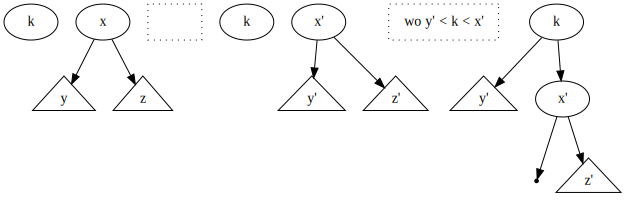

In [21]:
# flake8: noqa
y1 = Node("y", None, None); z1 = Node("z", None, None); x1 = Node("x", y1, z1); k1 = Node("k", None, None)
y2 = Node("y'", None, None); z2 = Node("z'", None, None); x2 = Node("x'", y2, z2); k2 = Node("k", None, None)
y3 = Node("y'", None, None); z3 = Node("z'", None, None); x3 = Node("x'", None, z3); k3 = Node("k", y3, x3)

dot = k1.graph(x1, Method(""), k2, x2, Method("wo y' < k < x'"), k3)
for subtree in y1, z1, y2, z2, y3, z3:
    dot.node(str(id(subtree)), shape="triangle")
dot

Im Fall, dass $k$ größer als die Wurzel $x$ des gesplayten Baums $B' = \text{Node}(x, y, z)$ ist, sind umgekehrt alle Elemente in dessen rechten Teilbaum $z$ größer als $k$, und wir setzen die Wurzel dieses Baumes $x$ als linken Teilbaum des neuen Elements $k$, wobei dieser Knoten dann als linken Teilbaum $y$ hat, als rechten Teilbaum $\text{Nil}$.

$$B.\text{splay}(k) = \text{Node}(x, y, z) \land k > x \Rightarrow B.\text{insert}(k) = \text{Node}(k, \text{Node}(x, y, \text{Nil}), z)$$

und graphisch:

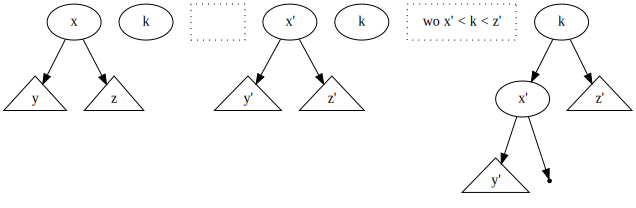

In [22]:
# flake8: noqa
y1 = Node("y", None, None); z1 = Node("z", None, None); x1 = Node("x", y1, z1); k1 = Node("k", None, None)
y2 = Node("y'", None, None); z2 = Node("z'", None, None); x2 = Node("x'", y2, z2); k2 = Node("k", None, None)
y3 = Node("y'", None, None); z3 = Node("z'", None, None); x3 = Node("x'", y3, None); k3 = Node("k", x3, z3)

dot = x1.graph(k1, Method(""), x2, k2, Method("wo x' < k < z'"), k3)
for subtree in y1, z1, y2, z2, y3, z3:
    dot.node(str(id(subtree)), shape="triangle")
dot

In [23]:
def insert(self, payload):
    self = self._splay(payload)
    if self._arb_eq(payload, self.payload):
        return self
    if self._arb_lt(payload, self.payload):
        tmp = self.left
        self.left = None
        return Node(payload, tmp, self)
    tmp = self.right
    self.right = None
    return Node(payload, self, tmp)


Node.insert = insert
del insert

Für den leeren Baum brauchen wir nur das Element in einen neuen Knoten setzen. Wir definieren – unter anderem zur Betrachtung des Falls des leeren Baumes – die Klasse `SplayTree`, die das Management des leeren Baums wie auch der Tatsache, dass sich bei einem Splay die Wurzel ändert, nach außen vereinfacht.

In [24]:
class SplayTree:
    def __init__(self):
        self.tree = None

    def graph(self):
        if self.tree is None:
            return Digraph()
        return self.tree.graph()

    def insert(self, payload):
        if self.tree is None:
            self.tree = Node(payload, None, None)
        else:
            self.tree = self.tree.insert(payload)

Einige Beispiele zeigen das Einsetzen von Knoten in Splay Trees:

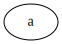

In [25]:
my_splay = SplayTree()
my_splay.insert("a")
my_splay.graph()

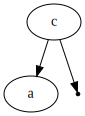

In [26]:
my_splay.insert("c")
my_splay.graph()

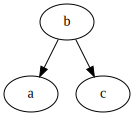

In [27]:
my_splay.insert("b")
my_splay.graph()

### Entfernen

Wir definieren als nächstes das Entfernen eines Elementes. Wir splayen wieder am zu entfernenden Element und haben dann einen Baum, der das zu entfernende Element als Wurzel hat. Sollte sich nach dem Splayen herausstellen, dass das Element nicht vorhanden ist, werfen wir einen `KeyError`, [da sich so auch die Mengen in Python verhalten](https://docs.python.org/3.8/library/stdtypes.html#set "Python Software Foundation (2019): The Python Standard Library/Built-in Types/set, Python Documentation"). In der Definition schreiben wir $\downarrow$ für das Undefinierte. Dies tritt auch ein, wenn der Baum leer ist:

$$B = \text{Nil} \Rightarrow B.\text{remove}(k)\downarrow$$
$$B.\text{splay}(k) \neq \text{Node}(k, x, y) \Rightarrow B.\text{remove}(k)\downarrow$$

Andernfalls überprüfen wir, ob ein Teilbaum des gesplayten Baums leer ist. In diesem Fall ist der neue Baum einfach der andere Teilbaum.

$$B.\text{splay}(k) = \text{Node}(k, \text{Nil}, x) \Rightarrow B.\text{remove}(k) = x$$
$$B.\text{splay}(k) = \text{Node}(k, x, \text{Nil}) \Rightarrow B.\text{remove}(k) = x$$

Ist das nicht der Fall, so sorgen wir dafür, dass der linke Teilbaum des gesplayten Baums keinen rechten Teilbaum mehr hat, sodass wir den rechten Teilbaum des gesplayten Baums anfügen können. Eine Grafik illustriert, was gemeint ist:

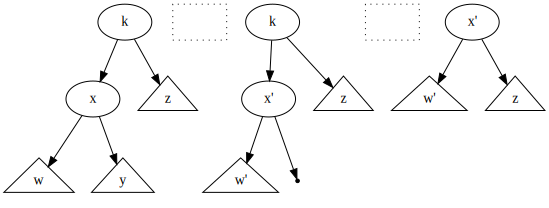

In [28]:
# flake8: noqa
w1 = Node("w", None, None); y1 = Node("y", None, None); z1 = Node("z", None, None); x1 = Node("x", w1, y1); k1 = Node("k", x1, z1)
w2 = Node("w'", None, None); z2 = Node("z", None, None); x2 = Node("x'", w2, None); k2 = Node("k", x2, z2)
w3 = Node("w'", None, None); z3 = Node("z", None, None); x3 = Node("x'", w3, z3)

dot = k1.graph(Method(""), k2, Method(""), x3)
for subtree in w1, y1, z1, w2, z2, w3, z3:
    dot.node(str(id(subtree)), shape="triangle")
dot

Wir machen aus dem Baum $\text{Node}(x, w, y)$ den Baum $\text{Node}(x', w', \text{Nil})$, indem wir an $k$ splayen. Da das Maximum aus $\text{Node}(x, w, y)$ kleiner $k$ ist, muss dann gerade dieses Maximum die Wurzel ($x'$) werden und kann keinen rechten Teilbaum mehr haben.

$$B.\text{splay}(k) = \text{Node}(k, \text{Node}(x, w, y), z) \land \text{Node}(x, w, y).\text{splay}(k) = \text{Node}(x', w', \text{Nil}) \Rightarrow B.\text{remove}(k) = \text{Node}(x', w', z)$$

Wir werfen in der Implementierung erst auf Ebene von `SplayTree` den `KeyError`, um im Baum noch aufräumen zu können. Der Nutzer könnte ja im Falle eines `KeyError`s diesen auffangen wollen und die Menge trotzdem noch benutzen wollen.

In [29]:
def remove(self, payload):
    self = self._splay(payload)
    if not self._arb_eq(payload, self.payload):
        return False, self
    if self.left is None:
        return True, self.right
    if self.right is None:
        return True, self.left
    tmp = self.right
    self = self.left._splay(payload)
    self.right = tmp
    return True, self

Node.remove = remove
del remove


def remove(self, payload):
    if self.tree is None:
        raise KeyError(payload)
    rc, self.tree = self.tree.remove(payload)
    if not rc:
        raise KeyError(payload)

SplayTree.remove = remove
del remove

Einige Beispiele zeigen das Entfernen von Elementen.

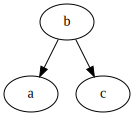

In [30]:
my_splay = SplayTree()
for letter in ["a", "c", "b"]:
    my_splay.insert(letter)
my_splay.graph()

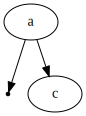

In [31]:
my_splay.remove("b")
my_splay.graph()

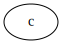

In [32]:
my_splay.remove("a")
my_splay.graph()

### Finden

Wir definieren als nächstes das Überprüfen eines Baumes auf ein Element. In unserer Definition wird ein Tupel aus dem Vorhandensein und der neuen Wurzel zurückgegeben.

Wir splayen am gesuchten Element und können schon an der Wurzel erkennen, ob das Element vorhanden ist. Noch einfacher haben wir es, wenn keine Elemente im Baum sind:

$$B = \text{Nil} \Rightarrow B.\text{contains}(k) = (\text{false}, \text{Nil})$$
$$B.\text{splay}(k) = \text{Node}(k, y, z) \Rightarrow B.\text{contains}(k) = (\text{true}, \text{Node}(k, y, z))$$
$$B.\text{splay}(k) = \text{Node}(x, y, z) \land k \neq x \Rightarrow B.\text{contains}(k) = (\text{false}, \text{Node}(x, y, z))$$

In [33]:
def contains(self, payload):
    self = self._splay(payload)
    return self._arb_eq(payload, self.payload), self


Node.contains = contains
del contains


def contains(self, payload):
    if self.tree is None:
        return False
    contains, self.tree = self.tree.contains(payload)
    return contains


SplayTree.contains = contains
del contains

Beispiele zeigen uns:

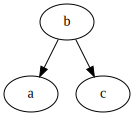

In [34]:
my_splay = SplayTree()
for letter in ["a", "c", "b"]:
    my_splay.insert(letter)
my_splay.graph()

In [35]:
my_splay.contains("a")

True

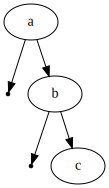

In [36]:
my_splay.graph()

In [37]:
my_splay.contains("d")

False

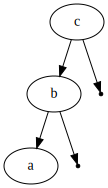

In [38]:
my_splay.graph()

### Leerüberprüfung

Wir definieren zuletzt, wie wir überprüfen, ob der Baum leer ist.

$$\text{Node} = \text{Nil} \Rightarrow \text{Node}.\text{is_empty}() = \text{true}$$
$$\text{Node} \neq \text{Nil} \Rightarrow \text{Node}.\text{is_empty}() = \text{false}$$

Die Implementierung findet von `SplayTree` aus statt.

In [39]:
def is_empty(self):
    return self.tree is None


SplayTree.is_empty = is_empty
del is_empty

In [40]:
my_splay = SplayTree()
my_splay.is_empty()

True

In [41]:
my_splay.insert("a")
my_splay.is_empty()

False

## Anwendungsbeispiel: Sieb des Eratosthenes

Als Anwendungsbeispiel benutzen wir den `SplayTree` als Menge, um alle Primzahlen bis zu einem Maximum abzulegen. Die Primzahlen werden dabei mit dem Sieb des Eratosthenes berechnet. Die Implementierung ist sehr einfach gehalten und hat Raum für Optimierungen, aber das ist für den Vergleich mit `set` unproblematisch.

In [42]:
def splay_primes(n):
    primes = SplayTree()
    for i in range(2, n + 1):
        primes.insert(i)
    for i in range(2, n + 1):
        for j in range(2 * i, n + 1, i):
            if primes.contains(j):
                primes.remove(j)
    return primes

Wir berechnen probeweise die Primzahlen bis 100. Vor dem Anzeigen splayen wir noch an einzelnen Knoten sowie am Median der Primzahlen bis 100, 41. Nach dem Sieb des Eratosthenes ist der Baum sehr unbalanciert, so wird die Anzeige etwas lesefreundlicher.

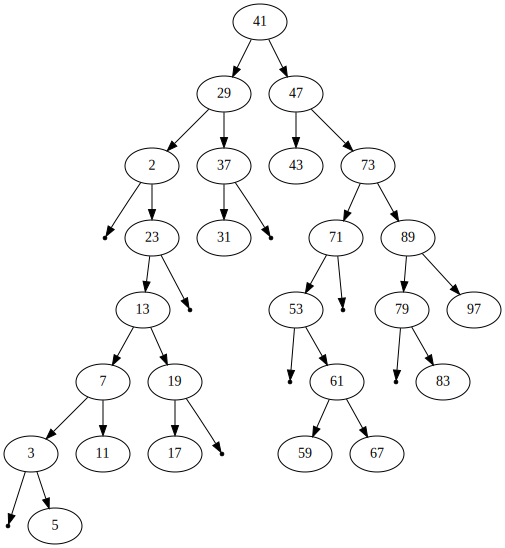

In [43]:
primes = splay_primes(100)
for i in range(0, 100, 25):
    primes.tree = primes.tree._splay(i)
primes.tree = primes.tree._splay(41)
primes.graph()

Wir wiederholen die Implementierung mit dem eingebauten `set`.

In [44]:
def set_primes(n):
    primes = set()
    for i in range(2, n + 1):
        primes.add(i)
    for i in range(2, n + 1):
        for j in range(2 * i, n + 1, i):
            primes -= set([j])
    return primes

In [45]:
print(set_primes(100))

{2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97}


Wir betrachten nun vergleichend die Ausführungszeiten beider Varianten.

In [46]:
# Ignore missing whitespace around operator because this is actually a flag
# Ignore syntax error that flake8 sees due to a compatibility issue
splay_times = %timeit -o splay_primes(10**4)  # noqa: E225, E999
splay_time = splay_times.best
set_times = %timeit -o set_primes(10**4)  # noqa: E225
set_time = set_times.best
if splay_time > set_time:
    print(f"Splaying was {round(splay_time / set_time, 2)} times slower")
else:
    print(f"Splaying was {round(set_time / splay_time, 2)} times faster")

430 ms ± 18.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
21.6 ms ± 1.1 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
Splaying was 21.03 times slower


Dabei ist zu beachten, dass wir zu diesem Zeitpunkt die Python-Implementierung mit einer C-Implementierung vergleichen.

## Mengen auf Basis von Splay Trees

Wir benutzen nun die Splay Trees, um Mengen (`set`) in Python mit Ordnung zu unterstützen.

Dazu bauen wir die hier gelisteten Methoden nach ([Permalink zur Datei, aus der dies generiert wird](https://github.com/python/cpython/blob/3.8/Objects/setobject.c "R. D. Hettinger et al. (2019): cpython/Objects/setobject.c, GitHub")):

In [47]:
help(set)

Help on class set in module builtins:

class set(object)
 |  set() -> new empty set object
 |  set(iterable) -> new set object
 |  
 |  Build an unordered collection of unique elements.
 |  
 |  Methods defined here:
 |  
 |  __and__(self, value, /)
 |      Return self&value.
 |  
 |  __contains__(...)
 |      x.__contains__(y) <==> y in x.
 |  
 |  __eq__(self, value, /)
 |      Return self==value.
 |  
 |  __ge__(self, value, /)
 |      Return self>=value.
 |  
 |  __getattribute__(self, name, /)
 |      Return getattr(self, name).
 |  
 |  __gt__(self, value, /)
 |      Return self>value.
 |  
 |  __iand__(self, value, /)
 |      Return self&=value.
 |  
 |  __init__(self, /, *args, **kwargs)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  __ior__(self, value, /)
 |      Return self|=value.
 |  
 |  __isub__(self, value, /)
 |      Return self-=value.
 |  
 |  __iter__(self, /)
 |      Implement iter(self).
 |  
 |  __ixor__(self, value, /)
 |      Re

### Konstruktion

Wenn wir das Konstruieren eines Sets aus einem `iterable` unterstützen wollen, begegnen wir dem Problem der Implementierung von *Mengen von Mengen*.

Seien $M, N$ Mengen und $M \in N$. $N$ ist also eine Menge von Mengen. Wie stellen wir sicher, dass $N$ geordnet bleibt, wenn $M$ geändert wird? Wir könnten verlangen, dass in $N$ eine Menge, wann immer sie preisgegeben wird, neu einsortiert werden muss. Abgesehen vom damit verbundenen Berechnungsaufwand ist dies aber nicht praktikabel, da auf $M$ auch Referenzen gehalten werden können, die nicht von $N$ abhängig sind, und somit $M$ geändert werden könnte, ohne dass $N$ davon erfährt. (Die $N$-seitige Überwachung aller gehaltenen Mengen wäre noch unpraktischer als das erneute Einsortieren.)

Ein vergleichbares Problem ergibt sich übrigens auch bei den Hashtabellen in der Referenzimplementierung CPython. Hier kann keine Ordnungsbedingung verletzt werden, jedoch ist im Allgemeinen eine Menge nach Änderung nicht mehr unter ihrem vorigen Hash zu finden. Der Python-Standard gibt daher vor, dass es strenggenommen keine Mengen von Mengen gibt – [es gibt nur Mengen von unmodifizierbaren Mengen](https://docs.python.org/3.8/library/stdtypes.html#set "Python Software Foundation (2019): The Python Standard Library/Built-in Types/set, Python Documentation"), den `frozenset`s.

Auch diese wollen wir geordnet haben und werden sie parallel mitimplementieren. Unsere Klassen `OrderedSet` und `OrderedFrozenset` erben je von `set` und `frozenset`.

In [48]:
class OrderedSet(set):
    pass

class OrderedFrozenset(frozenset):
    pass

Wir werden immer wieder Mengen einfrieren wollen und haben dafür die als intern markierte Methode `_freeze`.

In [49]:
def _freeze(self, element):
    if isinstance(element, OrderedSet):
        frozen = OrderedFrozenset()
        frozen._tree = element._tree
        return frozen
    elif isinstance(element, set):
        return OrderedFrozenset(element)
    return element

OrderedSet._freeze = OrderedFrozenset._freeze = _freeze
del _freeze

Konstruieren wir nun eine Menge aus einem `iterable`, so fügen wir die Elemente einzeln ein. Wir arbeiten direkt mit `Node`s, wrappen also nicht noch zusätzlich einen `SplayTree`.

In [50]:
def __init__(self, iterable=[]):
    self._tree = None
    iterator = iter(iterable)
    try:
        self._tree = Node(self._freeze(next(iterator)), None, None)
        while True:
            self._tree = self._tree.insert(self._freeze(next(iterator)))
    except StopIteration:
        pass

OrderedSet.__init__ = OrderedFrozenset.__init__ = __init__
del __init__

### Iteration

Bevor wir in Reihenfolge der `help`-Seite mit `__and__` fortfahren können, benötigen wir `__iter__`, um durch die Elemente in der Menge iterieren zu können.

Dies erreichen wir, indem wir den Baum wie bei einer *Inorder*-Ausgabe durchlaufen, wobei wir zur Ausgabe das Keyword `yield` benutzen. Die Implementierung ist iterativ und hält sich einen eigenen Stapel, da dieser in seiner Größe weniger begrenzt ist als der Aufrufstapel, der sich bei einer rekursiven Implementierung aufbauen würde. Für diesen Stapel benutzen wir [`deque`](https://docs.python.org/3.8/library/collections.html#collections.deque "Python Software Foundation (2019): The Python Standard Library/Data Types/collections/deque, Python Documentation") (double-ended queue) aus den `collections` der Standard Library, da sich diese für größere Stapel besser eignet als die Liste.

In [51]:
def __iter__(self):
    stack = deque()
    tree = self._tree
    while stack or tree is not None:
        if tree is not None:
            stack.append(tree)
            tree = tree.left
            continue
        tree = stack.pop()
        yield tree.payload
        tree = tree.right

OrderedSet.__iter__ = OrderedFrozenset.__iter__ = __iter__
del __iter__

### Minimum und Maximum

Für das mit `__and__` verwandte `__iand__` benötigen wir außerdem die *zusätzliche* Methode `minimum`. Mit `__iter__` funktioniert zwar bereits das Built-in `min`, wir können dies mit einem Baum aber effizienter gestalten: Wir geben die Nutzlast des linkesten Knotens zurück. Wir nehmen aufgrund der Ähnlichkeit `maximum` gleich dazu, bei der wir die Nutzlast des rechtesten Knotens zurückgeben.

In [52]:
def minimum(self):
    while self.left is not None:
        self = self.left
    return self.payload


def maximum(self):
    while self.right is not None:
        self = self.right
    return self.payload


Node.minimum = minimum
Node.maximum = maximum
del minimum, maximum


def minimum(self):
    if self._tree is None:
        raise ValueError("Set is empty")
    return self._tree.minimum()


def maximum(self):
    if self._tree is None:
        raise ValueError("Set is empty")
    return self._tree.maximum()


OrderedSet.minimum = OrderedFrozenset.minimum = minimum
OrderedSet.maximum = OrderedFrozenset.maximum = maximum
del minimum, maximum

### Hinzufügen und Entfernen

Wir benötigen für `__and__` und das verwandte `__iand__` außerdem noch `add` und `remove`, das Hinzufügen bzw. Entfernen eines Elementes, und implementieren diese ähnlich wie beim `SplayTree`. Wir implementieren auch `discard`, welches ähnlich zu `remove` ist, aber keinen Fehler verursacht, falls das Element nicht vorhanden ist.

In [53]:
def add(self, element):
    if self._tree is None:
        self._tree = Node(self._freeze(element), None, None)
    else:
        self._tree = self._tree.insert(self._freeze(element))


def remove(self, element):
    if self._tree is None:
        raise KeyError(element)
    rc, self._tree = self._tree.remove(element)
    if not rc:
        raise KeyError(element)


def discard(self, element):
    if self._tree is not None:
        _, self._tree = self._tree.remove(element)


OrderedSet.add = add
OrderedSet.remove = remove
OrderedSet.discard = discard
del add, remove, discard

`add`, `remove` und `discard` sind **keine** Methoden von `OrderedFrozenset`, weil diese Operationen die Menge modifizieren!

### Schnittmenge

Wir kehren zurück zur Reihenfolge der `help`-Seite und implementieren als nächstes `__and__` (`&`) und die verwandte `intersection`. Beide Methoden berechnen die Schnittmenge ($\cap$) zweier Mengen, haben jedoch nicht ganz dasselbe Verhalten. `__and__` funktioniert nur mit Mengen, und operiert auf nur eine zusätzliche Menge; hingegen nimmt `intersection` beliebig viele iterable Sammlungen. Wir werden daher `intersection` implementieren und `__and__` mit seinen eigenen Begrenzungen `intersection` aufrufen lassen.

Wir machen aus allen zu schneidenden Sammlungen `OrderedSet`s, falls sie nicht schon welche sind, und iterieren dann simultan durch diese Sammlungen, wobei wir von den simultan betrachteten Elementen immer alle wegwerfen, die kleiner als das Maximum der betrachteten Elemente sind, und genau dann ein Element in unsere neue Menge aufnehmen, wenn alle betrachteten Elemente gleich sind.

Für das Maximum definieren wir `Node._arb_max`, um im Stil von `_arb_gt` ein Maximum aus beliebigen Elementen berechnen zu können.

In [54]:
def _arb_max(self, arg, *args):
    maximum = arg
    for el in args:
        if self._arb_gt(el, arg):
            maximum = el
    return maximum

Node._arb_max = _arb_max
del _arb_max


def intersection(self, *args):
    sets = [self] + [OrderedSet(x) if type(x) not in
                     (OrderedSet, OrderedFrozenset) else x for x in args]
    iters = {id(x): iter(x) for x in sets}
    intersection = OrderedSet()
    try:
        items = {k: next(v) for k, v in iters.items()}
        while True:
            max_of_items = self._tree._arb_max(*items.values())
            all_equal = True
            for k, v in items.items():
                if self._tree._arb_lt(v, max_of_items):
                    all_equal = False
                    items[k] = next(iters[k])
            if all_equal:
                intersection.add(next(iter(items.values())))  # arbitrary item
                items = {k: next(iters[k]) for k in items.keys()}
    except StopIteration:
        pass
    return intersection

OrderedSet.intersection = OrderedFrozenset.intersection = intersection
del intersection

Für `__and__` begrenzen wir entsprechend die Eingabe. Wir benötigen auch `__rand__` (reverse `__and__`), bei welchem die Operanden vertauscht sind. Die Relation $\cap$ verhält sich jedoch kommutativ, weshalb in der Implementierung lediglich die Fehlermeldung beim `TypeError` von `__and__` verschieden ist.

In [55]:
def __and__(self, arg):
    if isinstance(arg, set) or isinstance(arg, frozenset):
        return self.intersection(arg)
    else:
        raise TypeError("unsupported operand type(s) for &: " +
                        f"'{type(self).__name__}' and '{type(arg).__name__}'")


def __rand__(self, arg):
    if isinstance(arg, set) or isinstance(arg, frozenset):
        return self.intersection(arg)
    else:
        raise TypeError("unsupported operand type(s) for &: " +
                        f"'{type(arg).__name__}' and '{type(self).__name__}'")


OrderedSet.__and__ = OrderedFrozenset.__and__ = __and__
OrderedSet.__rand__ = OrderedFrozenset.__rand__ = __rand__
del __and__, __rand__

### Schnittmenge in-place

Verwandt mit diesen Methoden sind `__iand__` (`&=`) und `intersection_update`, die die Schnittmenge *in-place* berechnen, das heißt, sie überschreiben die Menge direkt. Hier entfernen wir aus `self` alle Elemente, die nicht in allen übrigen Mengen zu finden sind. Wir iterieren parallel durch `self` und die anderen Mengen und entfernen ein Element aus `self`, sobald es in einer anderen Menge übersprungen wird. Weil der Baum fortlaufend geändert wird, ist `__iter__` für `self` ungeeignet. Wir iterieren daher, indem wir das Minimum splayen, und statt jedem `next` das Minimum aus dem rechten Teilbaum splayen. Somit ist der betrachtete Knoten immer die Wurzel.

Gerade weil diese Methoden die Menge überschreiben, sind sie keine Methoden von `OrderedFrozenset`.

In [56]:
def intersection_update(self, *args):
    if self._tree is None:
        return
    sets = [OrderedSet(x) if type(x) not in
            (OrderedSet, OrderedFrozenset) else x for x in args]
    iters = {id(x): iter(x) for x in sets}
    try:
        self._tree = self._tree._splay(self.minimum())
        items = {k: next(v) for k, v in iters.items()}
        while True:
            if self._tree.right is None:
                return  # self._tree is exhausted
            all_equal = True
            for k, v in items.items():
                if self._tree._arb_lt(v, self._tree.payload):
                    all_equal = False
                    items[k] = next(iters[k])
                elif self._tree._arb_gt(v, self._tree.payload):
                    all_equal = False
                    # next item in tree becomes root after deletion
                    self.remove(self._tree.payload)
                    if self._tree is None:
                        return  # set is empty
                    break  # break out of for loop since we have a new root
            if all_equal:
                # move on to next
                self._tree = self._tree._splay(self._tree.right.minimum())
    except StopIteration:
        # remove all larger than largest kept item
        self._tree.right = None


def __iand__(self, arg):
    if isinstance(arg, set) or isinstance(arg, frozenset):
        self.intersection_update(arg)
        return self
    else:
        raise TypeError("unsupported operand type(s) for &=: " +
                        f"'{type(self).__name__}' and '{type(arg).__name__}'")


OrderedSet.intersection_update = intersection_update
OrderedSet.__iand__ = __iand__
del intersection_update, __iand__

### Finden

Die nächste Operation auf der `help`-Seite ist `__contains__` (`in`), die wir für `Node` schon implementiert haben.

In [57]:
def __contains__(self, element):
    if self._tree is None:
        return False
    contains, self._tree = self._tree.contains(element)
    return contains

OrderedSet.__contains__ = OrderedFrozenset.__contains__ = __contains__
del __contains__

### Boolesche Relationen zwischen Mengen

Wir definieren als nächstes Relationen zwischen Mengen, die als Ergebnis einen Wahrheitswert haben, nämlich Aussagen über Gleichheit und Teilmengen. Das sind

|Methodenname|Operator in Python|Operator in der Mengenlehre|
|:----------:|:----------------:|:-------------------------:|
|`__eq__`    |`==`              |$=$                        |
|`__ge__`    |`>=`              |$\supseteq$                |
|`__gt__`    |`>`               |$\supset$                  |
|`__le__`    |`<=`              |$\subseteq$                |
|`__lt__`    |`<`               |$\subset$                  |
|`__ne__`    |`!=`              |$\neq$                     |

wobei mit $\supset$ und $\subset$ ausdrücklich $\supsetneq$ und $\subsetneq$ gemeint sind, also die echte Ober- bzw. Teilmenge. Im folgenden Text bezeichnen wir die Operationen anhand des Operators in Python.

Für alle diese Operationen geben wir sofort `False` zurück, falls das andere Objekt keine Menge oder eingefrorene Menge ist. Andernfalls sortieren wir es, indem wir es in eine geordnete Menge einsetzen, womit wir parallel durch die Mengen iterieren können. Diese Funktionalität lagern wir in `_prepare_relation` aus. Optional kann `_prepare_relation` mit dem Flag `sets_only=False` ausgeführt werden; dann muss der Parameter lediglich iterabel sein, aber keine Menge. Dies benutzen wir für `issubset` und `issuperset`, die wie `<=` und `>=` arbeiten, aber nicht nur auf Mengen operieren können.

In [58]:
def _prepare_relation(self, arg, sets_only=True):
    if sets_only:
        if not isinstance(arg, set) and not isinstance(arg, frozenset):
            return False
    if type(arg) not in (OrderedSet, OrderedFrozenset):
        return OrderedSet(arg)
    else:
        return arg

OrderedSet._prepare_relation = _prepare_relation
OrderedFrozenset._prepare_relation = _prepare_relation
del _prepare_relation

Für `==` geben wir `False` zurück, sobald zwei Elemente unterschiedlich sind, und überprüfen, wenn eine Iteration beendet ist, dass auch die andere beendet ist. Bei `!=` invertieren wir einfach das Ergebnis von `==`.

In [59]:
def __eq__(self, arg):
    other = self._prepare_relation(arg)
    if other is False:
        return False
    x_iter, y_iter = iter(self), iter(other)
    while True:
        try:
            x_item = next(x_iter)
        except StopIteration:
            try:  # assert y is also exhausted
                next(y_iter)
            except StopIteration:
                return True
            return False
        try:
            y_item = next(y_iter)
        except StopIteration:
            return False  # x was not exhausted
        if not self._tree._arb_eq(x_item, y_item):
            return False


def __ne__(self, arg):
    return not self == arg


OrderedSet.__eq__ = OrderedFrozenset.__eq__ = __eq__
OrderedSet.__ne__ = OrderedFrozenset.__ne__ = __ne__
del __eq__, __ne__

Für `>=` und `<=` sowie für `issuperset` und `issubset` definieren wir `_subseteq`, welches von geordneten Mengen $x, y$ die Relation $x \subseteq y$ überprüft. So brauchen wir für die eigentlichen Methoden nur `_prepare` und `_subseteq` mit den entsprechenden Parametern aufrufen.

Hier gehen wir für jedes Element aus $x$ so lange in $y$ weiter, bis die Elemente gleich sind. In diesem Fall gehen wir in beiden Mengen ein Element weiter. Ist ein Element aus $y$ größer, so kam ein Element aus $x$ nicht in $y$ vor, und wir verneinen die Relation $\subseteq$. Ist $x$ erschöpft, so waren alle Elemente in $y$. Ist $y$ erschöpft, so war mindestens ein Element von $x$ nicht in $y$.

In [60]:
def _subseteq(self, x, y):
    x_iter, y_iter = iter(x), iter(y)
    while True:
        try:
            x_item = next(x_iter)
        except StopIteration:
            return True
        while True:
            try:
                y_item = next(y_iter)
            except StopIteration:
                return False
            if self._tree._arb_lt(x_item, y_item):
                return False
            if self._tree._arb_eq(x_item, y_item):
                break


def __ge__(self, arg):
    other = self._prepare_relation(arg)
    return self._subseteq(other, self)


def issuperset(self, arg):
    other = self._prepare_relation(arg, sets_only=False)
    return self._subseteq(other, self)


def __le__(self, arg):
    other = self._prepare_relation(arg)
    return self._subseteq(self, other)


def issubset(self, arg):
    other = self._prepare_relation(arg, sets_only=False)
    return self._subseteq(self, other)


OrderedSet._subseteq = OrderedFrozenset._subseteq = _subseteq
OrderedSet.__ge__ = OrderedFrozenset.__ge__ = __ge__
OrderedSet.issuperset = OrderedFrozenset.issuperset = issuperset
OrderedSet.__le__ = OrderedFrozenset.__le__ = __le__
OrderedSet.issubset = OrderedFrozenset.issubset = issubset
del _subseteq, __ge__, issuperset, __le__, issubset

Für `>` und `<` definieren wir `_subsetneq`, welches $x \subset y$ überprüft. Hier halten wir uns die auf `False` initialisierte Variable `proper_subset`, mit deren Hilfe wir sicherstellen, dass $x$ eine echte Teilmenge von $y$ ist. Sie wird auf `True` gesetzt, sobald ein Element aus $y$ kleiner ist als aus $x$. Ist $x$ erschöpft und `proper_subset` nicht `True`, so prüfen wir, ob noch Elemente in $y$ sind, dann ist ebenfalls $x \subset y$.

In [61]:
def _subsetneq(self, x, y):
    x_iter, y_iter = iter(x), iter(y)
    proper_subset = False
    while True:
        try:
            x_item = next(x_iter)
        except StopIteration:
            if not proper_subset:
                try:  # assert y is not exhausted
                    next(y_iter)
                except StopIteration:
                    return False
            return True
        while True:
            try:
                y_item = next(y_iter)
            except StopIteration:
                return False
            if self._tree._arb_lt(x_item, y_item):
                return False
            if self._tree._arb_gt(x_item, y_item):
                proper_subset = True
            else:
                break


def __gt__(self, arg):
    other = self._prepare_relation(arg)
    return self._subsetneq(other, self)


def __lt__(self, arg):
    other = self._prepare_relation(arg)
    return self._subsetneq(self, other)


OrderedSet._subsetneq = OrderedFrozenset._subsetneq = _subsetneq
OrderedSet.__gt__ = OrderedFrozenset.__gt__ = __gt__
OrderedSet.__lt__ = OrderedFrozenset.__lt__ = __lt__
del _subsetneq, __gt__, __lt__

### Vereinigungsmenge

Wir implementieren als nächstes Vereinigungsmengen ($\cup$), für die wir einfach alle Elemente hinzufügen. Wie für `intersection`, welches beliebig viele Iterable erlaubt, und für `__and__`, welches genau eine Menge erlaubt, haben wir jetzt entsprechend `union` und `__or__` (`|`). Das umgekehrte `__ror__` funktioniert wie `__or__`, abgesehen von der Fehlermeldung.

In [62]:
def union(self, *args):
    union = OrderedSet(self)
    for arg in args:
        for el in arg:
            union.add(el)
    return union


def __or__(self, arg):
    if isinstance(arg, set) or isinstance(arg, frozenset):
        return self.union(arg)
    else:
        raise TypeError("unsupported operand type(s) for |: " +
                        f"'{type(self).__name__}' and '{type(arg).__name__}'")


def __ror__(self, arg):
    if isinstance(arg, set) or isinstance(arg, frozenset):
        return self.union(arg)
    else:
        raise TypeError("unsupported operand type(s) for |: " +
                        f"'{type(arg).__name__}' and '{type(self).__name__}'")


OrderedSet.union = OrderedFrozenset.union = union
OrderedSet.__or__ = OrderedFrozenset.__or__ = __or__
OrderedSet.__ror__ = OrderedFrozenset.__ror__ = __ror__
del union, __or__, __ror__

*In-place* sind die entsprechenden Operationen `update` und `__ior__` (`|=`). Hier operieren wir direkt auf `self`. Diese Methoden ordnen wir nicht `OrderedFrozenset` zu, da die Menge überschrieben wird.

In [63]:
def update(self, *args):
    for arg in args:
        for el in arg:
            self.add(el)


def __ior__(self, arg):
    if isinstance(arg, set) or isinstance(arg, frozenset):
        self.update(arg)
        return self
    else:
        raise TypeError("unsupported operand type(s) for |=: " +
                        f"'{type(self).__name__}' and '{type(arg).__name__}'")


OrderedSet.update = update
OrderedSet.__ior__ = __ior__
del update, __ior__

### Differenzmenge

Es folgt die Differenzmenge ($\setminus$), für die wir einfach alle Elemente entfernen. Diesmal haben wir `difference` und `__sub__` (`-`). `__rsub__` allerdings verhält sich nicht kommutativ, sodass wir auch für den erfolgreichen Teil die Operanden umdrehen.

In [64]:
def difference(self, *args):
    difference = OrderedSet(self)
    for arg in args:
        for el in arg:
            difference.discard(el)
    return difference


def __sub__(self, arg):
    if isinstance(arg, set) or isinstance(arg, frozenset):
        return self.difference(arg)
    else:
        raise TypeError("unsupported operand type(s) for -: " +
                        f"'{type(self).__name__}' and '{type(arg).__name__}'")


def __rsub__(self, arg):
    if isinstance(arg, set) or isinstance(arg, frozenset):
        return arg.difference(self)
    else:
        raise TypeError("unsupported operand type(s) for -: " +
                        f"'{type(arg).__name__}' and '{type(self).__name__}'")


OrderedSet.difference = OrderedFrozenset.difference = difference
OrderedSet.__sub__ = OrderedFrozenset.difference = __sub__
OrderedSet.__rsub__ = OrderedFrozenset.difference = __rsub__
del difference, __sub__, __rsub__

In-place haben wir `difference_update` und `__isub__` (`-=`).

In [65]:
def difference_update(self, *args):
    for arg in args:
        for el in arg:
            self.discard(el)


def __isub__(self, arg):
    if isinstance(arg, set) or isinstance(arg, frozenset):
        self.difference_update(arg)
        return self
    else:
        raise TypeError("unsupported operand type(s) for -=: " +
                        f"'{type(self).__name__}' and '{type(arg).__name__}'")


OrderedSet.difference_update = difference_update
OrderedSet.__isub__ = __isub__
del difference_update, __isub__

### Symmetrische Differenz

Für die symmetrische Differenz ($\bigtriangleup$) brauchen wir out-of-place `symmetric_difference` sowie `__xor__` (`^`) und umgekehrt `__rxor__`. Wir iterieren parallel durch die Mengen, berechnen dabei das Minimum unter den gerade betrachteten Elementen und speichern auch, welche Elemente dieses Minimum sind. Wenn dies genau ein Element war, so wird es in die Ergebnismenge aufgenommen, andernfalls gehen wir weiter.

In [66]:
def symmetric_difference(self, *args):
    sets = [self] + [OrderedSet(x) if type(x) not in
                     (OrderedSet, OrderedFrozenset) else x for x in args]
    iters = {id(x): iter(x) for x in sets}
    sdifference = OrderedSet()
    items = dict()
    for k, v in iters.items():
        try:
            items[k] = next(v)
        except StopIteration:
            pass
    while items:
        fwd = deque()  # items to be forwarded
        for k, v in items.items():
            if not fwd:
                fwd.append((k, v))
                continue
            if self._tree._arb_eq(v, fwd[0][1]):
                fwd.append((k, v))
                continue
            if self._tree._arb_lt(v, fwd[0][1]):
                fwd.clear()
                fwd.append((k, v))
        if len(fwd) == 1:
            sdifference.add(fwd[0][1])
        for k, _ in fwd:
            try:
                items[k] = next(iters[k])
            except StopIteration:
                items.pop(k)
    return sdifference


def __xor__(self, arg):
    if isinstance(arg, set) or isinstance(arg, frozenset):
        return self.__xor__(arg)
    else:
        raise TypeError("unsupported operand type(s) for ^: " +
                        f"'{type(self).__name__}' and '{type(arg).__name__}'")


def __rxor__(self, arg):
    if isinstance(arg, set) or isinstance(arg, frozenset):
        return self.__xor__(arg)
    else:
        raise TypeError("unsupported operand type(s) for ^: " +
                        f"'{type(arg).__name__}' and '{type(self).__name__}'")


OrderedSet.symmetric_difference = symmetric_difference
OrderedFrozenset.symmetric_difference = symmetric_difference
OrderedSet.__xor__ = OrderedFrozenset.__xor__ = __xor__
OrderedSet.__rxor__ = OrderedFrozenset.__rxor__ = __rxor__
del symmetric_difference, __xor__, __rxor__